In [1]:
import scanpy
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import preprocessing, cluster
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
adata_beta = scanpy.read_h5ad('../data/beta_run_2.h5ad')
combined_pc_op = pd.read_pickle('results/combined_magic_pc_op.pkl')

In [5]:
scanpy.pp.highly_variable_genes(adata_beta)
hvgs = adata_beta.var[adata_beta.var['highly_variable']]['names'].values

In [14]:
backwards_trajectories_to_obob2 = np.load('results/islet_run_combined_magic_pca_5_tp_run1_growth/backward_trajectories_OBOB_AT2.npy')
tnet_traj = pd.DataFrame(columns=hvgs)
for time in tqdm(range(100)):
    t = np.linspace(0, 4, 100)[::-1][time]

    tp = pd.DataFrame(combined_pc_op.inverse_transform(backwards_trajectories_to_obob2[time] * np.std(adata_beta.obsm['combined_magic_pc'][:, 0]))[:, adata_beta.var['highly_variable']],
                      columns=hvgs)

    tp['timepoint'] = t
    tnet_traj = pd.concat((tnet_traj, tp), ignore_index=True)
all_values_scaled_1 = pd.DataFrame(preprocessing.scale(tnet_traj.groupby('timepoint').mean()).T, index=hvgs)

100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


In [15]:
# repeat for run 2
backwards_trajectories_to_obob2 = np.load('results/islet_run_combined_magic_pca_5_tp_run2_growth/backward_trajectories_OBOB_AT2.npy')
tnet_traj = pd.DataFrame(columns=hvgs)
for time in tqdm(range(100)):
    t = np.linspace(0, 4, 100)[::-1][time]

    tp = pd.DataFrame(combined_pc_op.inverse_transform(backwards_trajectories_to_obob2[time] * np.std(adata_beta.obsm['combined_magic_pc'][:, 0]))[:, adata_beta.var['highly_variable']],
                      columns=hvgs)

    tp['timepoint'] = t
    tnet_traj = pd.concat((tnet_traj, tp), ignore_index=True)
all_values_scaled_2 = pd.DataFrame(preprocessing.scale(tnet_traj.groupby('timepoint').mean()).T, index=hvgs)

100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


In [16]:
# take mean of both runs
all_values_scaled = (all_values_scaled_1 + all_values_scaled_2)/2

In [23]:
km = cluster.KMeans(random_state=42, n_clusters=2)
km.fit(all_values_scaled)

/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=42)

In [27]:
def plot_clusters(genes, cl, values):
    ulabels = np.unique(cl)
    
    df = values.T.reset_index().melt(id_vars=['index'], value_vars=[*genes])
    
    df['cluster'] = np.repeat(cl, values.shape[1])
    df.columns = ['time', 'variable', 'scaled expression', 'cluster']
    
    g = sns.relplot(x='time', 
                    y='scaled expression', 
                    hue='cluster', 
                    kind='line',
                    col='cluster',
                    data=df, 
                    palette='Set1', 
                    legend='full', 
                    col_wrap=3,
                    errorbar='sd')
    
    plt.savefig('figures/gene_clusters.png', dpi=600)

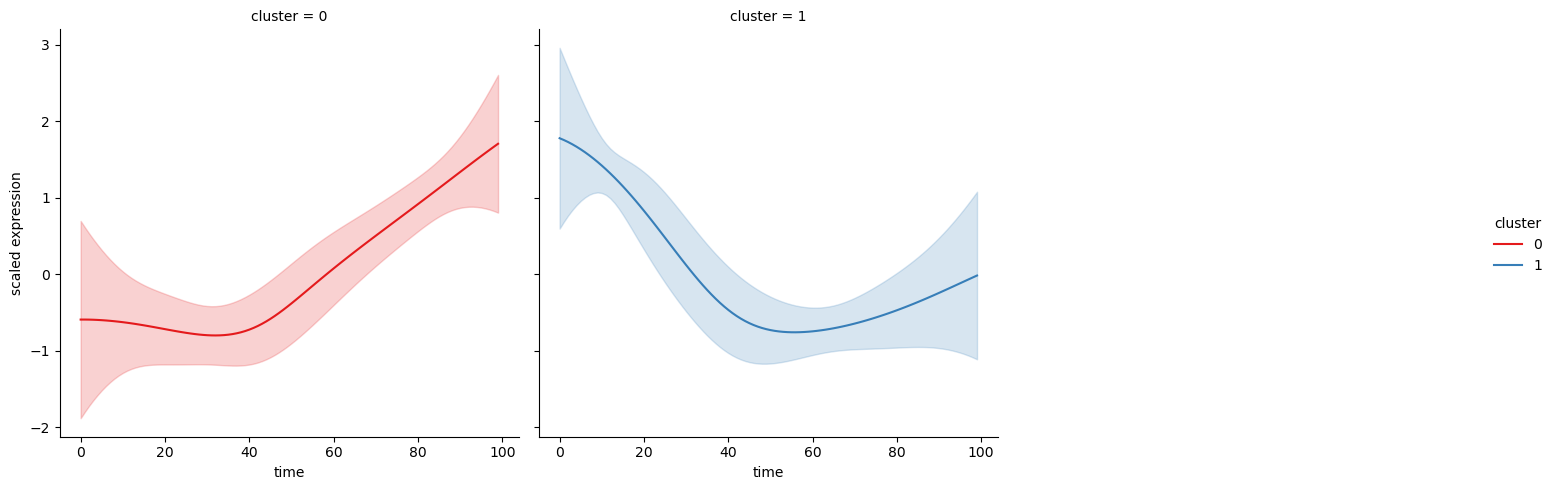

In [32]:
plot_clusters(hvgs, km.labels_, all_values_scaled)

In [48]:
clust_labels = pd.DataFrame((adata_beta.var.query('highly_variable').index, hvgs, adata_beta.var.query('highly_variable')['human_name'], km.labels_)).T
clust_labels.columns = ['ensembl', 'mouse', 'human', 'cluster']
clust_labels.to_csv('results/proliferation_2_clusters_top_hvgs.csv')

In [54]:
trrust = pd.read_csv('data/trrust_rawdata.human.tsv', sep='\t', header=None)
tfs = np.unique(trrust[0])
tfs = list(map(lambda x: x.capitalize(), tfs))
beta_hvg_tfs = np.array(list(set(tfs).intersection(hvgs)))
all_pvalues = np.zeros((len(beta_hvg_tfs), len(hvgs)))

for i,tf in tqdm(enumerate(beta_hvg_tfs)):
    for j,gene in enumerate(hvgs):
        res = grangercausalitytests(all_values_scaled.loc[[gene, tf]].T,
                                    maxlag=[10], verbose=False)
        pvalue = res[10][0]['ssr_chi2test'][1]
        
        all_pvalues[i][j] = pvalue

129it [32:11, 14.98s/it]


In [ ]:
granger_scores = -np.log(all_pvalues) * np.sign(corr.loc[beta_hvg_tfs, hvgs]).values

In [65]:
granger_scores = scanpy.AnnData(granger_scores)
granger_scores.layers['all_pvalues'] = all_pvalues
granger_scores.obs_names = beta_hvg_tfs
granger_scores.var_names = hvgs
granger_scores.varm['hvgs_over_time'] = all_values_scaled.values

In [90]:
granger_scores.write('results/granger_causality.h5ad')